<font color=blue><font size =6> Data Explanation </font></font><br>
이 데이터는 시계열 데이터 예측을 위한 Sample1(5)로 자세한 내용은 데이터 보안성에 의해 유출불가
-> 따라서 일부 결과에 output이 누락 돼있을 수 있다( 단 중요 output은 나와있음 )

Temporal Fusion Transformer를 사용해서 Interval prediction을 해보겠다

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [19]:
from pytorch_forecasting.data import TimeSeriesDataSet
from pytorch_forecasting.models import TemporalFusionTransformer
from pytorch_forecasting.metrics import QuantileLoss
from pytorch_forecasting.metrics import RMSE,SMAPE
from pytorch_lightning.callbacks import LearningRateFinder,EarlyStopping


import pytorch_lightning as pl

In [29]:
data = pd.read_csv('../data/5.csv')
data.rename(columns={'a':'group_ids'},inplace=True)
data['group_ids']=np.tile('0',len(data))
data

,group_ids,b,values,c,d
0,0,2018-07-25 00:00:00,92408,26971036,177711644
1,0,2018-07-25 00:01:00,92150,26948190,220370286
2,0,2018-07-25 00:02:00,94896,26238222,188035073
3,0,2018-07-25 00:03:00,92694,26087970,191997884
4,0,2018-07-25 00:04:00,93674,25314568,169497214
...,...,...,...,...,...
38875,0,2018-08-20 23:55:00,81521,23637112,138239574
38876,0,2018-08-20 23:56:00,83092,24617816,164460450
38877,0,2018-08-20 23:57:00,84873,25101336,173568370
38878,0,2018-08-20 23:58:00,81736,24181689,157334718


<AxesSubplot: >

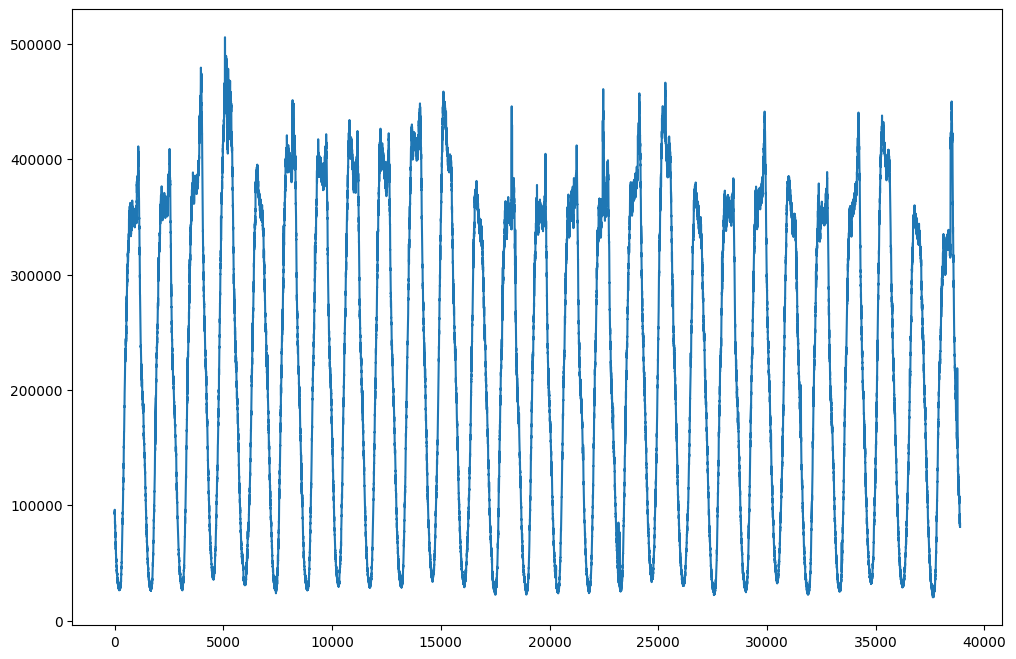

In [30]:
data['values'].plot(figsize=(12,8))
# 일정한 주기성 패턴이 보임을 알 수 있음 DeepAR 테스트셋 길이수정

In [31]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [32]:
seasonal_data = data.copy()
seasonal_data

,group_ids,b,values,c,d
0,0,2018-07-25 00:00:00,92408,26971036,177711644
1,0,2018-07-25 00:01:00,92150,26948190,220370286
2,0,2018-07-25 00:02:00,94896,26238222,188035073
3,0,2018-07-25 00:03:00,92694,26087970,191997884
4,0,2018-07-25 00:04:00,93674,25314568,169497214
...,...,...,...,...,...
38875,0,2018-08-20 23:55:00,81521,23637112,138239574
38876,0,2018-08-20 23:56:00,83092,24617816,164460450
38877,0,2018-08-20 23:57:00,84873,25101336,173568370
38878,0,2018-08-20 23:58:00,81736,24181689,157334718


In [33]:
seasonal_data.set_index('b',inplace=True)

<AxesSubplot: xlabel='b'>

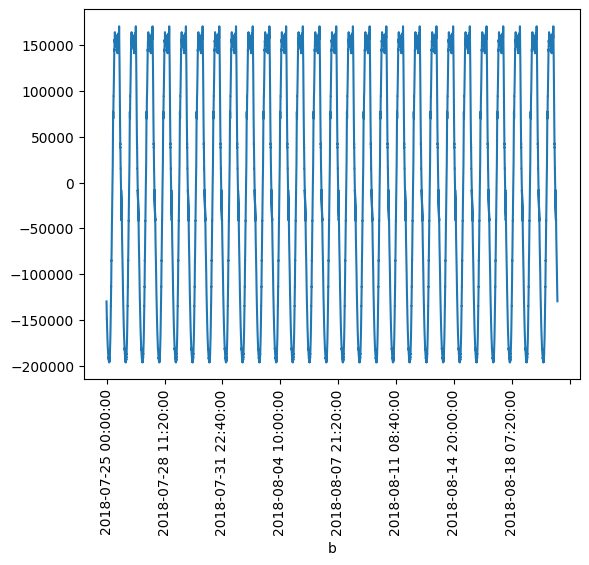

In [34]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition=seasonal_decompose(seasonal_data[['values']],period=60*24)
# 뷴데이터니깐 period = 60*24
decomposition.seasonal.plot(rot=90)

<font color = blue><font size = 3> 일별 계절성이 있는 것으로 확인된다 </font></font>
&rightarrow; 따라서 1일치 데이터를 예측하도록 해보자(TFT는 Long Time Series Forecasting에 유리하기 때문)

Q)내가 plot을 그리고 눈으로 확인하는 방법 말고 컴퓨터가 계절성을 계산해주는 방법은 없나

[수정]<br>
&rightarrow; 위에 seasonal decompose는 진정한 seasonality가 아니고 trend를 뺏을때 생기는 residual이다
따라서 seasonality는 내가 직접 판단을 내려야한다

In [35]:
data.drop(columns=['c','d'],inplace=True)
data

,group_ids,b,values
0,0,2018-07-25 00:00:00,92408
1,0,2018-07-25 00:01:00,92150
2,0,2018-07-25 00:02:00,94896
3,0,2018-07-25 00:03:00,92694
4,0,2018-07-25 00:04:00,93674
...,...,...,...
38875,0,2018-08-20 23:55:00,81521
38876,0,2018-08-20 23:56:00,83092
38877,0,2018-08-20 23:57:00,84873
38878,0,2018-08-20 23:58:00,81736


In [36]:
data['b']=pd.to_datetime(data['b'])

In [37]:
data['values']=pd.to_numeric(data['values'],downcast='float')

In [38]:
data['time_idx']=np.arange(len(data))
data

,group_ids,b,values,time_idx
0,0,2018-07-25 00:00:00,92408.0,0
1,0,2018-07-25 00:01:00,92150.0,1
2,0,2018-07-25 00:02:00,94896.0,2
3,0,2018-07-25 00:03:00,92694.0,3
4,0,2018-07-25 00:04:00,93674.0,4
...,...,...,...,...
38875,0,2018-08-20 23:55:00,81521.0,38875
38876,0,2018-08-20 23:56:00,83092.0,38876
38877,0,2018-08-20 23:57:00,84873.0,38877
38878,0,2018-08-20 23:58:00,81736.0,38878


In [39]:
max_prediction_length = 1440 # forecast 1 Day
max_encoder_length = 2880 # use 2 Day
training_cutoff = max(data['time_idx'])-max_prediction_length
training_cutoff

37439

In [40]:
data[lambda x : x['time_idx']<=training_cutoff]

,group_ids,b,values,time_idx
0,0,2018-07-25 00:00:00,92408.0,0
1,0,2018-07-25 00:01:00,92150.0,1
2,0,2018-07-25 00:02:00,94896.0,2
3,0,2018-07-25 00:03:00,92694.0,3
4,0,2018-07-25 00:04:00,93674.0,4
...,...,...,...,...
37435,0,2018-08-19 23:55:00,72901.0,37435
37436,0,2018-08-19 23:56:00,72965.0,37436
37437,0,2018-08-19 23:57:00,72281.0,37437
37438,0,2018-08-19 23:58:00,70918.0,37438


In [131]:
training = TimeSeriesDataSet(
    data[lambda x : x['time_idx']<=training_cutoff],
    max_encoder_length = max_encoder_length,
    min_encoder_length = max_encoder_length,
    min_prediction_length = max_prediction_length,
    max_prediction_length = max_prediction_length,
    time_idx = 'time_idx',
    group_ids = ['group_ids'],
    target = 'values',
    time_varying_unknown_reals=['values'],
    time_varying_known_reals=["time_idx"],
    
)
training

TimeSeriesDataSet[length=33121](
	time_idx='time_idx',
	target='volumn',
	group_ids=['group_ids'],
	weight=None,
	max_encoder_length=2880,
	min_encoder_length=2880,
	min_prediction_idx=0,
	min_prediction_length=1440,
	max_prediction_length=1440,
	static_categoricals=[],
	static_reals=[],
	time_varying_known_categoricals=[],
	time_varying_known_reals=['time_idx'],
	time_varying_unknown_categoricals=[],
	time_varying_unknown_reals=['volumn'],
	variable_groups={},
	constant_fill_strategy={},
	allow_missing_timesteps=False,
	lags={},
	add_relative_time_idx=False,
	add_target_scales=False,
	add_encoder_length=False,
	target_normalizer=EncoderNormalizer(
	method='standard',
	center=True,
	max_length=None,
	transformation='relu',
	method_kwargs={}
),
	categorical_encoders={'__group_id__group_ids': NaNLabelEncoder(add_nan=False, warn=True)},
	scalers={'time_idx': StandardScaler()},
	randomize_length=None,
	predict_mode=False
)

#predict=True, randomize=False로 해두면 모델이 안돌아감
min_prediction_idx = training_cutoff+1

"""
predict_mode (bool): if to only iterate over each timeseries once (only the last provided samples).
Effectively, this will take choose for each time series identified by ``group_ids``
the last ``max_prediction_length`` samples of each time series as
prediction samples and everthing previous up to ``max_encoder_length`` samples as encoder samples.

-> predict_mode를 True로 해두면 사용한 마지막 max_encoder_length 길이의 샘플을 사용해서
max_prediction_length만큼의 길이만큼을 예측하는 데이터셋을 뽑을것이다
"""

In [132]:
validation = TimeSeriesDataSet.from_dataset(
    training, data, predict=True,stop_randomization=True
)

validation

# Q>
# stop_randomization은  다음과 같이 적혀있는데
# stop_randomization (bool, optional): If to stop randomizing encoder and decoder lengths,
# 이는 encoder_length와 prediction_length를 TImeSeriesDataSet을 만들때 무작위로 선택하는걸
# 금한다는 의미이다 즉, 위에서 TimeSeriesDataSet을 만들때 max와min length를 다르게 설정하면 무작위로
# 설정된다는 의미인가?

# -> 자답
# 위의 추측이 맞는걸로 판단된다

TimeSeriesDataSet[length=1](
	time_idx='time_idx',
	target='volumn',
	group_ids=['group_ids'],
	weight=None,
	max_encoder_length=2880,
	min_encoder_length=2880,
	min_prediction_idx=0,
	min_prediction_length=1440,
	max_prediction_length=1440,
	static_categoricals=[],
	static_reals=[],
	time_varying_known_categoricals=[],
	time_varying_known_reals=['time_idx'],
	time_varying_unknown_categoricals=[],
	time_varying_unknown_reals=['volumn'],
	variable_groups={},
	constant_fill_strategy={},
	allow_missing_timesteps=False,
	lags={},
	add_relative_time_idx=False,
	add_target_scales=False,
	add_encoder_length=False,
	target_normalizer=EncoderNormalizer(
	method='standard',
	center=True,
	max_length=None,
	transformation='relu',
	method_kwargs={}
),
	categorical_encoders={'__group_id__group_ids': NaNLabelEncoder(add_nan=False, warn=True)},
	scalers={'time_idx': StandardScaler()},
	randomize_length=None,
	predict_mode=True
)

In [141]:
batch_size = 16
train_dataloader = training.to_dataloader(
    train=True, batch_size=batch_size, num_workers=0
)
val_dataloader = validation.to_dataloader(
    train=False, batch_size=batch_size, num_workers=0
)

In [142]:
for x,y in val_dataloader:
    print(y[0])
    print(y[0].shape)

tensor([[71104., 69093., 67786.,  ..., 84873., 81736., 81236.]])
torch.Size([1, 1440])


In [163]:
lr_find = LearningRateFinder(min_lr = 1e-3,
                            max_lr = 10,early_stop_threshold=10)
early_stopping = EarlyStopping(monitor = 'val_loss', min_delta = 1e-2,
                               patience = 10, verbose = True, mode = "min")

In [164]:
import torch
print(torch.cuda.is_available())

True


In [169]:
trainer = pl.Trainer(
    gpus=[0],
    gradient_clip_val=0.25,
    max_epochs=30,
    callbacks=[early_stopping,lr_find]
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [170]:
tft = TemporalFusionTransformer.from_dataset(training,lstm_layers=2,
                                             hidden_size = 16,
                                             output_size = 7, #since loss is quantile,
                                             loss = QuantileLoss(),
                                             optimizer = 'adam',
                                             attention_head_size=4,
                                             learning_rate = 0.25,
                                             reduce_on_plateau_patience=4,
                                             time_varying_reals_encoder=["volumn"],
                                             time_varying_reals_decoder=["volumn"]
                                             )
TemporalFusionTransformer()
tft.size() #14379 parameters in model

19243

res = trainer.tuner.lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=1.0,
    min_lr=1e-6,
)

In [ ]:
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

In [ ]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_model_path

In [173]:
best_model = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [176]:
predictions=best_model.predict(val_dataloader,mode='prediction')
predictions

tensor([[40010.3438, 34933.7188, 33056.6094,  ..., 54212.0781, 49323.2812,
         48653.7656]])

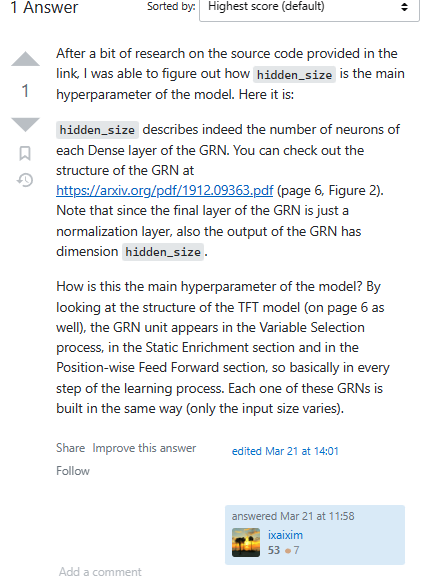
-> hidden_size의 의미

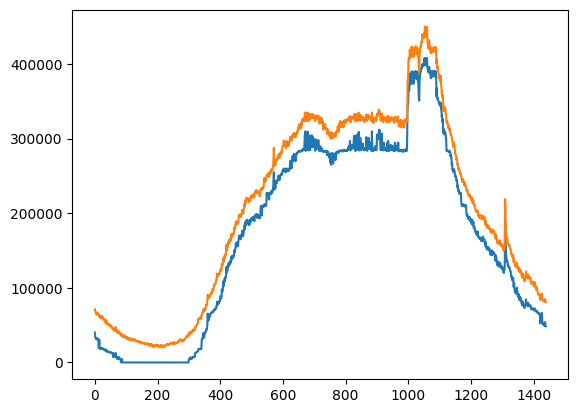

In [178]:
plt.plot(np.arange(1440),predictions[0])
plt.plot(np.arange(1440),data['values'].iloc[-1440:])

<font color = blue><font size = 6> revision process </font></font>
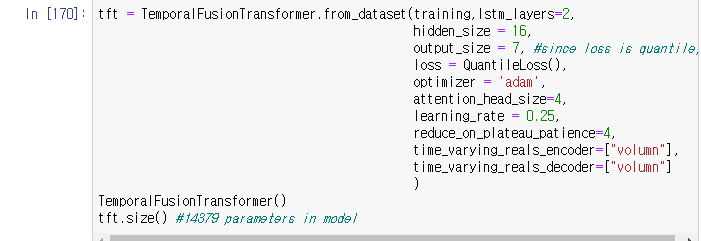
First try: 컴퓨팅 자원의 부족인지 cpu로만 사용했을때는 모델이 fitting이 안되고 알 수 없는 오류만 발생 시켰음 -> 교수님께 부탁드려 GPU를 사용했더니 해결<br>
Second try:<font color = blue> 모델의 loss가 5.64e+04 에서 줄어들지 않음 값자체가 크다보니 quantile loss값이 큰거는 어느정도 이해하겠는데 실제 prediction 값을 찍어본 경우 초반에만 튀는 값이 생기고 그이후로는 같은 값이 나옴</font>  구글링을 해보니 loss function의 문제라고 했지만 tft논문에서도 quantile loss를 기본으로 사용했기에 이는 배제하고 learning rate 가 local minima에 빠진건가 싶어서 learning rate를 극단적으로 키워보니(=1) loss가 오히려 튀는 현상이 발생함( 애초에 최적 learning rate를 찾아주는 pytorch lightning callback함수를 사용했기 때문에 문제가 될 것이 없었음)
다른 생각으로는 이게 decoder length가 1440정도로 극단적으로 길다고 생각이 돼서 gradient vanishing이 생기는건가 싶어서 데이터 크기자체를 줄여봤는데 진전이 없었음
parameter의 문제인가 싶어서 들여다 봤지만 pytorch-forecasting docs에 나와있는 tutorial를 참고해봤을때 더 추가해야하는 파라미터가 없어 보였는데<br>
&downarrow;<br>
위에 tft모델에서 time_varying_reals_encoder과 time_varying_real_decoder를 넣어주니깐 loss값이 감소됨이 보였음 하지만 극단적으로 작아진 것은 아니기 때문에 plot을 그려봤는데 꽤나 추세가 정확하게 반영됨을 확인 할 수 있었음

In [201]:
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_model.predict(val_dataloader,mode='prediction')
print(RMSE()(predictions,actuals))
print(SMAPE()(predictions,actuals))

tensor(32897.6836)
tensor(0.5346)


<font color = blue><font size = 6> Quantile Visualizing </font></font>

In [184]:
raw_predictions,x = best_model.predict(val_dataloader,mode="raw",return_x = True)

In [185]:
raw_predictions

Output(prediction=tensor([[[     0.0000,      0.0000,  63727.4531,  ...,  70249.5312,
           87703.2656,  52575.7344],
         [     0.0000,      0.0000,  58500.2031,  ...,  65021.7656,
           82405.8750,  46831.0156],
         [     0.0000,      0.0000,  56561.5000,  ...,  63054.4062,
           80542.4375,  44828.4688],
         ...,
         [     0.0000,      0.0000,  78055.8594,  ...,  85346.1953,
          100067.9766,  66026.4062],
         [     0.0000,      0.0000,  73130.5469,  ...,  80181.7656,
           95721.0391,  61278.9688],
         [     0.0000,      0.0000,  72456.0938,  ...,  79473.9688,
           95127.9844,  60631.3438]]]), encoder_attention=tensor([[[[3.1218e-06, 3.3778e-05, 7.2830e-05,  ..., 2.6983e-05,
           2.3363e-05, 2.1832e-05],
          [2.3474e-07, 9.2099e-06, 3.1509e-05,  ..., 7.0040e-06,
           5.3479e-06, 4.7368e-06],
          [5.9814e-05, 1.5392e-04, 2.0839e-04,  ..., 1.2795e-04,
           1.2176e-04, 1.1881e-04],
          [1.5

In [197]:
raw_predictions[0].shape

torch.Size([1, 1440, 7])

In [187]:
x

{'encoder_cat': tensor([], size=(1, 2880, 0), dtype=torch.int64),
 'encoder_cont': tensor([[[ 1.4656, -0.8023],
          [ 1.4657, -0.7917],
          [ 1.4658, -0.7859],
          ...,
          [ 1.7318, -1.0479],
          [ 1.7319, -1.0582],
          [ 1.7320, -1.0639]]]),
 'encoder_target': tensor([[105057., 106470., 107238.,  ...,  72281.,  70918.,  70155.]]),
 'encoder_lengths': tensor([2880]),
 'decoder_cat': tensor([], size=(1, 1440, 0), dtype=torch.int64),
 'decoder_cont': tensor([[[ 1.7321, -1.0568],
          [ 1.7322, -1.0718],
          [ 1.7323, -1.0816],
          ...,
          [ 1.8651, -0.9536],
          [ 1.8651, -0.9771],
          [ 1.8652, -0.9808]]]),
 'decoder_target': tensor([[71104., 69093., 67786.,  ..., 84873., 81736., 81236.]]),
 'decoder_lengths': tensor([1440]),
 'decoder_time_idx': tensor([[37440, 37441, 37442,  ..., 38877, 38878, 38879]]),
 'groups': tensor([[0]]),
 'target_scale': tensor([[212087.4219, 133410.7031]])}

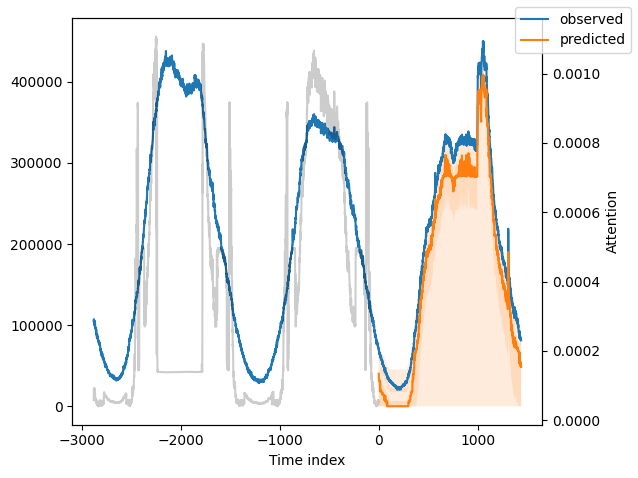

In [198]:
best_model.plot_prediction(x,raw_predictions,idx=0);
# epoch를 1번만 돌렸기에 idx는 0만 가능

<font color = blue><font size = 6> Real Future Forecasting </font></font>

In [288]:
all_training = TimeSeriesDataSet(
    data,
    max_encoder_length = max_encoder_length,
    min_encoder_length = max_encoder_length,
    min_prediction_length = max_prediction_length,
    max_prediction_length = max_prediction_length,
    time_idx = 'time_idx',
    group_ids = ['group_ids'],
    target = 'values',
    time_varying_unknown_reals=['values'],
    time_varying_known_reals=["time_idx"],
    
)
all_training

TimeSeriesDataSet[length=34561](
	time_idx='time_idx',
	target='volumn',
	group_ids=['group_ids'],
	weight=None,
	max_encoder_length=2880,
	min_encoder_length=2880,
	min_prediction_idx=0,
	min_prediction_length=1440,
	max_prediction_length=1440,
	static_categoricals=[],
	static_reals=[],
	time_varying_known_categoricals=[],
	time_varying_known_reals=['time_idx'],
	time_varying_unknown_categoricals=[],
	time_varying_unknown_reals=['volumn'],
	variable_groups={},
	constant_fill_strategy={},
	allow_missing_timesteps=False,
	lags={},
	add_relative_time_idx=False,
	add_target_scales=False,
	add_encoder_length=False,
	target_normalizer=EncoderNormalizer(
	method='standard',
	center=True,
	max_length=None,
	transformation='relu',
	method_kwargs={}
),
	categorical_encoders={'__group_id__group_ids': NaNLabelEncoder(add_nan=False, warn=True)},
	scalers={'time_idx': StandardScaler()},
	randomize_length=None,
	predict_mode=False
)

In [289]:
batch_size = 16
train_dataloader = all_training.to_dataloader(
    train=True, batch_size=batch_size, num_workers=0
)

In [290]:
early_stopping = EarlyStopping(monitor = 'train_loss', min_delta = 1e-2,
                               patience = 10, verbose = True, mode = "min")
trainer = pl.Trainer(
    gpus=[0],
    gradient_clip_val=0.1,
    max_epochs=30,
    callbacks=[early_stopping,lr_find]
)

/home/sjlee/sj_virtual/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:441: LightningDeprecationWarning: Setting `Trainer(gpus=[0])` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=[0])` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [291]:
tft = TemporalFusionTransformer.from_dataset(all_training,lstm_layers=2,
                                             hidden_size = 16,
                                             output_size = 7, #since loss is quantile,
                                             loss = QuantileLoss(),
                                             optimizer = 'adam',
                                             attention_head_size=4,
                                             learning_rate = 0.25,
                                             reduce_on_plateau_patience=4,
                                             time_varying_reals_encoder=["values","time_idx"],
                                             time_varying_reals_decoder=["time_idx"]
                                             )
TemporalFusionTransformer()
tft.size() #14379 parameters in model

/home/sjlee/sj_virtual/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/sjlee/sj_virtual/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


19865

In [ ]:
trainer.fit(
    tft,
    train_dataloaders=train_dataloader
)

In [ ]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_model_path

In [297]:
best_model = TemporalFusionTransformer.load_from_checkpoint('best_model_path')

/home/sjlee/sj_virtual/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/sjlee/sj_virtual/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


In [298]:
pred,x=best_model.predict(new_prediction_data,mode='prediction',return_x=True)
pred

tensor([[54396.2656, 54649.2812, 54416.0469,  ..., 54350.9844, 54350.9844,
         54350.9844]])

In [221]:
new_encoder_data = data[lambda x: x['time_idx'] > (x['time_idx'].max() - max_encoder_length)]
new_encoder_data

,group_ids,datetime,volumn,time_idx
36000,0,2018-08-19 00:00:00,94479.0,36000
36001,0,2018-08-19 00:01:00,94558.0,36001
36002,0,2018-08-19 00:02:00,93968.0,36002
36003,0,2018-08-19 00:03:00,92061.0,36003
36004,0,2018-08-19 00:04:00,90326.0,36004
...,...,...,...,...
38875,0,2018-08-20 23:55:00,81521.0,38875
38876,0,2018-08-20 23:56:00,83092.0,38876
38877,0,2018-08-20 23:57:00,84873.0,38877
38878,0,2018-08-20 23:58:00,81736.0,38878


In [219]:
datetime=pd.date_range(start='2018-08-21 00:00:00',periods = 1440,freq='T')

In [222]:
# 우리는 known covariate data가 없으므로
new_decoder_data = pd.DataFrame({'group_ids':np.repeat('0',max_prediction_length),
                               'b':datetime,
                               'values':np.repeat(data['values'].iloc[-1],max_prediction_length),
                               'time_idx':np.arange(38880,38880+max_prediction_length)})
new_decoder_data

,group_ids,datetime,volumn,time_idx
0,0,2018-08-21 00:00:00,81236.0,38880
1,0,2018-08-21 00:01:00,81236.0,38881
2,0,2018-08-21 00:02:00,81236.0,38882
3,0,2018-08-21 00:03:00,81236.0,38883
4,0,2018-08-21 00:04:00,81236.0,38884
...,...,...,...,...
1435,0,2018-08-21 23:55:00,81236.0,40315
1436,0,2018-08-21 23:56:00,81236.0,40316
1437,0,2018-08-21 23:57:00,81236.0,40317
1438,0,2018-08-21 23:58:00,81236.0,40318


In [260]:
new_prediction_data = pd.concat([new_encoder_data,new_decoder_data],ignore_index=True,axis=0)
new_prediction_data

,group_ids,datetime,volumn,time_idx
0,0,2018-08-19 00:00:00,94479.0,36000
1,0,2018-08-19 00:01:00,94558.0,36001
2,0,2018-08-19 00:02:00,93968.0,36002
3,0,2018-08-19 00:03:00,92061.0,36003
4,0,2018-08-19 00:04:00,90326.0,36004
...,...,...,...,...
4315,0,2018-08-21 23:55:00,81236.0,40315
4316,0,2018-08-21 23:56:00,81236.0,40316
4317,0,2018-08-21 23:57:00,81236.0,40317
4318,0,2018-08-21 23:58:00,81236.0,40318


In [278]:
new_raw_predictions,new_x = best_model.predict(new_prediction_data,mode='prediction',return_x=True)

In [279]:
new_raw_predictions

tensor([[202475.0000, 202473.6719, 202473.6562,  ..., 202473.6250,
         202473.6250, 202473.6250]])

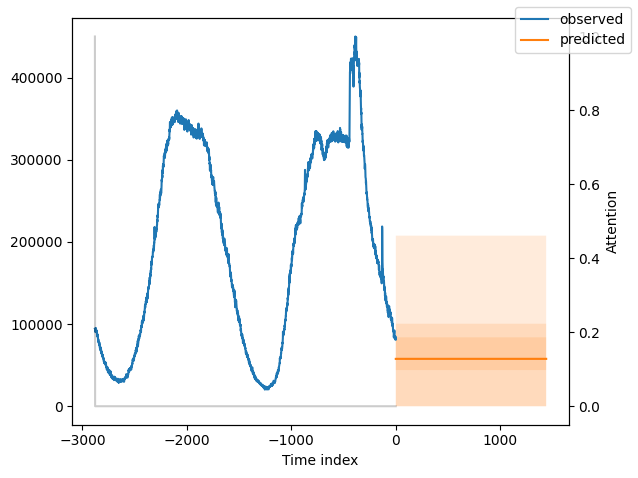

In [249]:
best_model.plot_prediction(new_x,new_raw_predictions,idx=0,show_future_observed=False);

결과적으로 하나의 값에만 의존하므로 그 값이 빠지면 예측이 이상해진다<br>
의존하는 값을 하나 더 만들어볼까?

<font color = blue><font size = 6>Final Forecasting </font></font>

In [41]:
data

,group_ids,b,values,time_idx
0,0,2018-07-25 00:00:00,92408.0,0
1,0,2018-07-25 00:01:00,92150.0,1
2,0,2018-07-25 00:02:00,94896.0,2
3,0,2018-07-25 00:03:00,92694.0,3
4,0,2018-07-25 00:04:00,93674.0,4
...,...,...,...,...
38875,0,2018-08-20 23:55:00,81521.0,38875
38876,0,2018-08-20 23:56:00,83092.0,38876
38877,0,2018-08-20 23:57:00,84873.0,38877
38878,0,2018-08-20 23:58:00,81736.0,38878


In [42]:
data['new_sub_pred']= np.tile(np.arange(1,1441),27)
data

,group_ids,b,values,time_idx,new_sub_pred
0,0,2018-07-25 00:00:00,92408.0,0,1
1,0,2018-07-25 00:01:00,92150.0,1,2
2,0,2018-07-25 00:02:00,94896.0,2,3
3,0,2018-07-25 00:03:00,92694.0,3,4
4,0,2018-07-25 00:04:00,93674.0,4,5
...,...,...,...,...,...
38875,0,2018-08-20 23:55:00,81521.0,38875,1436
38876,0,2018-08-20 23:56:00,83092.0,38876,1437
38877,0,2018-08-20 23:57:00,84873.0,38877,1438
38878,0,2018-08-20 23:58:00,81736.0,38878,1439


In [ ]:
final_training = TimeSeriesDataSet(
    data,
    max_encoder_length = max_encoder_length,
    min_encoder_length = max_encoder_length,
    min_prediction_length = max_prediction_length,
    max_prediction_length = max_prediction_length,
    time_idx = 'time_idx',
    group_ids = ['group_ids'],
    target = 'values',
    time_varying_unknown_reals=['values'],
    time_varying_known_reals=["time_idx","new_sub_pred"]
)
final_training

In [311]:
batch_size = 4
final_train_dataloader = final_training.to_dataloader(
    train=True, batch_size=batch_size, num_workers=0
)

In [312]:
tft = TemporalFusionTransformer.from_dataset(final_training,lstm_layers=2,
                                             hidden_size = 16,
                                             output_size = 7, #since loss is quantile,
                                             loss = QuantileLoss(),
                                             optimizer = 'adam',
                                             attention_head_size=4,
                                             learning_rate = 0.1,
                                             reduce_on_plateau_patience=4,
                                             time_varying_reals_encoder=["values","time_idx","new_sub_pred"],
                                             time_varying_reals_decoder=["time_idx","new_sub_pred"]
                                             )

/home/sjlee/sj_virtual/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/sjlee/sj_virtual/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


In [313]:
early_stopping = EarlyStopping(monitor = 'train_loss', min_delta = 1e-2,
                               patience = 10, verbose = True, mode = "min")
trainer = pl.Trainer(
    gpus=[0],
    gradient_clip_val=0.1,
    max_epochs=30,
    callbacks=[early_stopping,lr_find]
)

/home/sjlee/sj_virtual/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:441: LightningDeprecationWarning: Setting `Trainer(gpus=[0])` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=[0])` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
model = trainer.fit(tft,
                    final_train_dataloader)

In [ ]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_model_path

In [317]:
best_model = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

/home/sjlee/sj_virtual/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/sjlee/sj_virtual/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


In [320]:
# 우리는 known covariate data가 없으므로
new_decoder_data = pd.DataFrame({'group_ids':np.repeat('0',max_prediction_length),
                               'b':datetime,
                               'values':np.repeat(data['volumn'].iloc[-1],max_prediction_length),
                               'time_idx':np.arange(38880,38880+max_prediction_length),
                                'new_sub_pred':np.tile(np.arange(1,1441),1)})
new_encoder_data = data[lambda x: x['time_idx'] > (x['time_idx'].max() - max_encoder_length)]
new_prediction_data = pd.concat([new_encoder_data,new_decoder_data],ignore_index=True,axis=0)

In [322]:
new_raw_pred,x=best_model.predict(new_prediction_data,mode='raw',return_x=True)
new_raw_pred

Output(prediction=tensor([[[     0.0000,  33173.8438,  60892.7500,  ...,  89758.7031,
          104427.9453, 130388.7969],
         [     0.0000,  33051.8125,  60856.0469,  ...,  89654.9844,
          104347.6328, 130193.0312],
         [     0.0000,  32927.9844,  60818.7188,  ...,  89549.7031,
          104266.0781, 129994.3984],
         ...,
         [ 22387.4531,  69144.8672, 108796.3359,  ..., 139948.0000,
          158045.2344, 181409.7344],
         [ 22143.0781,  68874.7344, 108480.9141,  ..., 139588.1094,
          157678.6406, 181021.0938],
         [ 21900.6875,  68606.7969, 108167.9844,  ..., 139231.0938,
          157314.9375, 180635.5781]]]), encoder_attention=tensor([[[[3.5435e-04, 3.5444e-04, 3.5439e-04,  ..., 3.4729e-04,
           3.4730e-04, 3.4730e-04],
          [4.6142e-04, 4.6294e-04, 4.6394e-04,  ..., 4.5083e-04,
           4.5071e-04, 4.5070e-04],
          [3.4446e-04, 3.4452e-04, 3.4451e-04,  ..., 3.5167e-04,
           3.5162e-04, 3.5161e-04],
          [2.5

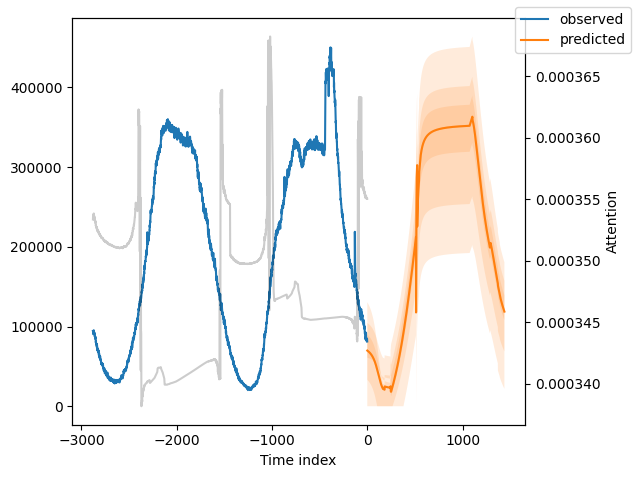

In [326]:
best_model.plot_prediction(x,new_raw_pred,idx=0, show_future_observed = False);
# prediction 결과가 1개밖에 안나오기 때문에 다음과 같이 결과가 나옴

<font color = blue><font size = 6>Final Conclusion</font></font><br>
결과적으로 참고할만한 지표를 미래시점에 투입해주니깐 그지표를 토대로 모델이 예측함을 볼 수 있었다 비교적 그래프가 smooth하게 나타나는 경향이 있는데 내가 유의미한 참고할만한 데이터를 한종류밖에 넣어주지 않아서 그렇다 추가적으로 Future Known Data를 알게 되면 모델의 성능이 아득히 더 좋아질 것으로 예측할 수 있다

I DID IT !!!!!!!!!!!!!!!!!!!!!!!!!!!!